In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

from neuralnetlib.preprocessing import MinMaxScaler, StandardScaler
from neuralnetlib.models import Sequential, GAN
from neuralnetlib.layers import Input, Dense, Reshape, Flatten, BatchNormalization, Dropout, Activation
from neuralnetlib.activations import LeakyReLU
from neuralnetlib.callbacks import EarlyStopping

In [2]:
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32')

Loading MNIST dataset...


C:\Users\marcp\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
dim = X.shape[1]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled.reshape(-1, dim)

latent_dim = 100

c:\users\marcp\documents\programming\python\neuralnetlib\neuralnetlib\preprocessing.py:288: RuntimeWarning: invalid value encountered in divide
  return (X - self.min_) / self.scale_ * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]


In [4]:
generator = Sequential(random_state=42)

generator.add(Input(latent_dim))

generator.add(Dense(256))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(512))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(1024))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(alpha=0.2)))

generator.add(Dense(dim, activation='tanh'))

In [5]:
discriminator = Sequential(random_state=42)

discriminator.add(Input(dim))

discriminator.add(Dense(512,input_dim=dim, activation="leakyrelu"))
discriminator.add(Dropout(0.4))

discriminator.add(Dense(256, activation="leakyrelu"))
discriminator.add(Dropout(0.4))

discriminator.add(Dense(1, activation='sigmoid'))

In [6]:
gan = GAN(latent_dim=latent_dim)
gan.compile(
    generator,
    discriminator,
    generator_optimizer='adam',
    discriminator_optimizer='adam',
    loss_function='bce',
    verbose=True
)

GAN(latent_dim=100, gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=1732408836496002100)
-------------------------------------------------
Generator:
Sequential(gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42)
-------------------------------------------------
Layer 1: Input(input_shape=(100,))
Layer 2: Dense(units=256)
Layer 3: BatchNormalization(momentum=0.99, epsilon=1e-08)
Layer 4: Activation(LeakyReLU)
Layer 5: Dense(units=512)
Layer 6: BatchNormalization(momentum=0.99, epsilon=1e-08)
Layer 7: Activation(LeakyReLU)
Layer 8: Dense(units=1024)
Layer 9: BatchNormalization(momentum=0.99, epsilon=1e-08)
Layer 10: Activation(LeakyReLU)
Layer 11: Dense(units=784)
Layer 12: Activation(Tanh)
-------------------------------------------------
Loss function: BinaryCrossentropy
Optimizer: Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clip_norm=None, clip_value=None)
----------------------------------------

In [7]:
epochs = 100
batch_size = 128
save_interval = 10

history = gan.fit(
    X_reshaped,
    epochs=epochs,
    batch_size=batch_size,
    verbose=True
)

disc_real_output range: nan to nan
d_loss_real: nan
d_error_real range: nan to nan
d_loss_fake: 0.6934436033758643
Final discriminator_loss: nan
[------------------------------] 0% Epoch 1/100 - d_loss: nan - g_loss: 0.7903 - 0.49sdisc_real_output range: nan to nan
d_loss_real: nan
d_error_real range: nan to nan
d_loss_fake: 0.6686893598534812
Final discriminator_loss: nan
[------------------------------] 0% Epoch 1/100 - d_loss: nan - g_loss: 0.8264 - 0.55sdisc_real_output range: nan to nan
d_loss_real: nan
d_error_real range: nan to nan
d_loss_fake: 0.6791731365307727
Final discriminator_loss: nan
[------------------------------] 0% Epoch 1/100 - d_loss: nan - g_loss: 0.8087 - 0.60sdisc_real_output range: nan to nan
d_loss_real: nan
d_error_real range: nan to nan
d_loss_fake: 0.7115018630827786
Final discriminator_loss: nan
[------------------------------] 0% Epoch 1/100 - d_loss: nan - g_loss: 0.8160 - 0.65sdisc_real_output range: nan to nan
d_loss_real: nan
d_error_real range: nan 

KeyboardInterrupt: 

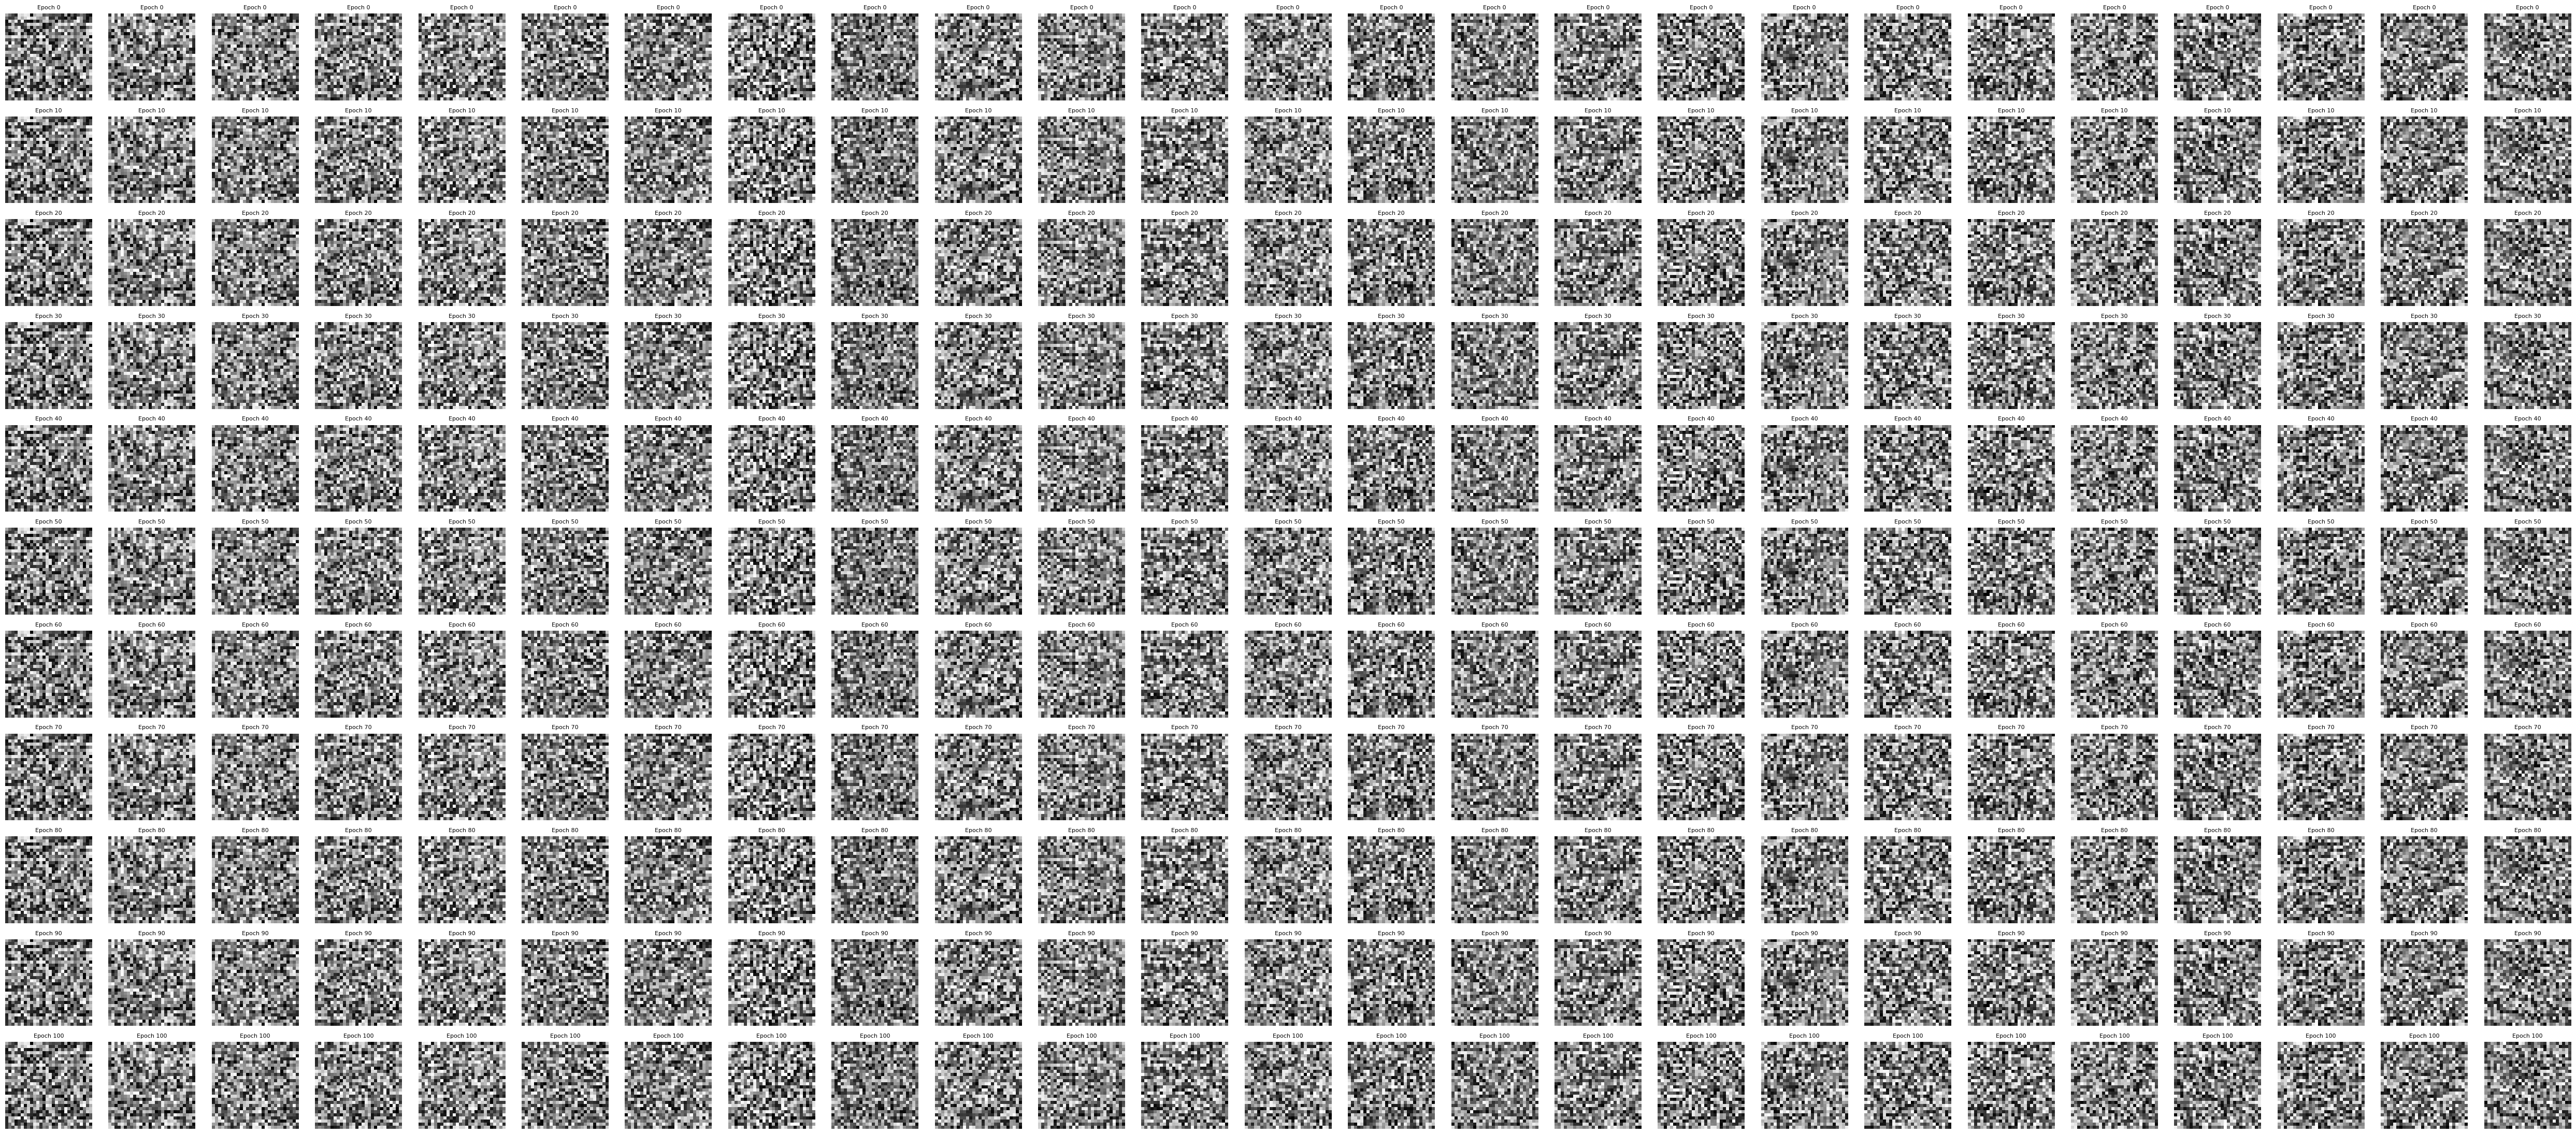

In [ ]:
import matplotlib.pyplot as plt

def show_generated_images_all_epochs(gan, epochs, save_interval, examples=25, dim=(5, 5)):
    examples = int(examples)
    total_images = (epochs // save_interval + 1) * examples
    rows = (epochs // save_interval + 1)
    cols = examples
    
    plt.figure(figsize=(cols * 2, rows * 2))

    for epoch in range(0, epochs + 1, save_interval):
        noise = gan._generate_latent_points(examples)
        generated_images = gan.predict(examples)
        generated_images = generated_images.reshape(examples, 28, 28)
        generated_images = (generated_images + 1) / 2.0
        
        for i in range(examples):
            plt.subplot(rows, cols, (epoch // save_interval) * examples + i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
            plt.title(f"Epoch {epoch}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

show_generated_images_all_epochs(gan, epochs, save_interval)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['discriminator_loss'], label='Discriminator Loss')
plt.plot(history['generator_loss'], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gan_training_history.png')
plt.close()

print("Saving model...")
gan.save('mnist_gan_model')